# Парсинг данных 

**Web парсинг** -  способ считывания различных данных, расположенных на веб-страницах, для их систематизации и дальнейшего анализа.

Открытые данные часто публикуют в форматах (таких как csv, json, xml), уобоных для загрузки в программы анализа, например: https://www.nalog.gov.ru/opendata/

Но существуют данные, даже открытые, которые доступны только в виде отдельных веб-страниц. Сбор данных с таких страниц становится отдельной задачей. Например:
https://www.gov.uk/find-out-if-a-company-is-in-financial-trouble

Процедуру Web парсинга можно разбить на два этапа:

1. отправка запроса на web-сайт и загрузка исходного кода страницы;
2. извлечение содержимого web-страницы. 


# Библиотека [Beautiful Soup](<https://www.crummy.com/software/BeautifulSoup/bs4/doc/>)


## Тестовый HTML
Намного проще чем реальные веб-страницы.

In [1]:
test = '''
    <html>
        <head><title>Some title</title></head>
        <body>
            <div class="content-box" id="main">
                <h2 align='center'> Some text </h2>
                <h2 align='left'> Another text </h2>
            </div>
            <h2> Last <b>text</b> </h2>
        </body>
    </html>
'''

### Создание объекта `BeautifulSoup`

In [2]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(test, 'html.parser')
soup


<html>
<head><title>Some title</title></head>
<body>
<div class="content-box" id="main">
<h2 align="center"> Some text </h2>
<h2 align="left"> Another text </h2>
</div>
<h2> Last <b>text</b> </h2>
</body>
</html>

### Базовые команды в Beautiful Soup для разбора HTML документа

In [3]:
# тег как объект
print(soup.title)
print(type(soup.title))

<title>Some title</title>
<class 'bs4.element.Tag'>


In [4]:
# str тега - просто напрямую его текст
soup.div

<div class="content-box" id="main">
<h2 align="center"> Some text </h2>
<h2 align="left"> Another text </h2>
</div>

In [5]:
# тег можно спросить - какой тег?
soup.title.name

'title'

In [6]:
# текстовое содержимое тега
soup.title.string

'Some title'

In [7]:
soup.h2

<h2 align="center"> Some text </h2>

In [8]:
# родитель тега
soup.title.parent

<head><title>Some title</title></head>

In [9]:
# дети тега
print(type(soup.div.children))
list(soup.div.children)

<class 'list_iterator'>


['\n',
 <h2 align="center"> Some text </h2>,
 '\n',
 <h2 align="left"> Another text </h2>,
 '\n']

In [10]:
type(list(soup.div.children)[0])

bs4.element.NavigableString

In [11]:
# аттрибуты тега доступны по имени как по ключу
print(soup.div.id)
soup.div['id']

None


'main'

Что если одинаковых тегов несколько?

In [12]:
soup.div.h2

<h2 align="center"> Some text </h2>

In [13]:
soup.h2

<h2 align="center"> Some text </h2>

In [14]:
soup.find_all('h2')

[<h2 align="center"> Some text </h2>,
 <h2 align="left"> Another text </h2>,
 <h2> Last <b>text</b> </h2>]

In [15]:
# find_all для удобства можно опостить - просто вызывая тег как функцию
soup('h2')

[<h2 align="center"> Some text </h2>,
 <h2 align="left"> Another text </h2>,
 <h2> Last <b>text</b> </h2>]

In [16]:
# какие объекты есть в BeautifulSoup?
type(soup), type(soup.title), type(soup.div.children), type(soup.title.string), type(soup('h2'))

(bs4.BeautifulSoup,
 bs4.element.Tag,
 list_iterator,
 bs4.element.NavigableString,
 bs4.element.ResultSet)

#### 1. найти h2 теги с атрибутом align равным center

In [17]:
soup("h2", align='center')

[<h2 align="center"> Some text </h2>]

#### 2. найти h2 теги у которых есть аттрибут align

In [18]:
soup('h2', align=True)

[<h2 align="center"> Some text </h2>, <h2 align="left"> Another text </h2>]

#### 3. извлечь текстовое содержимое тега с разметкой внутри

In [19]:
tag = soup('h2')[2]
tag

<h2> Last <b>text</b> </h2>

In [20]:
print(list(tag.children))

[' Last ', <b>text</b>, ' ']


In [21]:
print([c.string for c in tag.children])
print(''.join([c.string for c in tag.children]))

[' Last ', 'text', ' ']
 Last text 


In [22]:
print(tag.get_text())

 Last text 


In [23]:
soup.body

<body>
<div class="content-box" id="main">
<h2 align="center"> Some text </h2>
<h2 align="left"> Another text </h2>
</div>
<h2> Last <b>text</b> </h2>
</body>

In [24]:
print([c.string for c in soup.body.children])

['\n', None, '\n', None, '\n']


In [25]:
print(soup.body.string)

None


In [26]:
soup.body.get_text()

'\n\n Some text \n Another text \n\n Last text \n'

# Рассмотрим реальный HTML документ
В качестве примера возьмем статью из Википедии:  
<https://ru.wikipedia.org/wiki/Дубна>

## Протокол HTTP: библиотека [requests](https://2.python-requests.org/en/latest/)

### Отправляем GET запрос на web-сервер и загружаем HTML

In [27]:
import requests
r = requests.get('https://ru.wikipedia.org/wiki/Дубна')
r

<Response [200]>

In [28]:
r.status_code

200

In [29]:
print(type(r.content))

<class 'bytes'>


In [30]:
r.content[:1000]

b'<!DOCTYPE html>\n<html class="client-nojs" lang="ru" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>\xd0\x94\xd1\x83\xd0\xb1\xd0\xbd\xd0\xb0 \xe2\x80\x94 \xd0\x92\xd0\xb8\xd0\xba\xd0\xb8\xd0\xbf\xd0\xb5\xd0\xb4\xd0\xb8\xd1\x8f</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":[",\\t.","\xc2\xa0\\t,"],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","\xd1\x8f\xd0\xbd\xd0\xb2\xd0\xb0\xd1\x80\xd1\x8c","\xd1\x84\xd0\xb5\xd0\xb2\xd1\x80\xd0\xb0\xd0\xbb\xd1\x8c","\xd0\xbc\xd0\xb0\xd1\x80\xd1\x82","\xd0\xb0\xd0\xbf\xd1\x80\xd0\xb5\xd0\xbb\xd1\x8c","\xd0\xbc\xd0\xb0\xd0\xb9","\xd0\xb8\xd1\x8e\xd0\xbd\xd1\x8c","\xd0\xb8\xd1\x8e\xd0\xbb\xd1\x8c","\xd0\xb0\xd0\xb2\xd0\xb3\xd1\x83\xd1\x81\xd1\x82","\xd1\x81\xd0\xb5\xd0\xbd\xd1\x82\xd1\x8f\xd0\xb1\xd1\x80\xd1\x8c","\xd0\xbe\xd0\xba\xd1\x82\xd1\x8f\xd0\xb1\xd1\x80\xd1\x8c","\xd0\xbd\xd0\xbe\xd1\x8f\xd0\xb1\xd1\x80\xd1\x8c","\xd0\xb4\xd0\xb5\x

In [31]:
r.text

'<!DOCTYPE html>\n<html class="client-nojs" lang="ru" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>Дубна — Википедия</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":[",\\t.","\xa0\\t,"],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","январь","февраль","март","апрель","май","июнь","июль","август","сентябрь","октябрь","ноябрь","декабрь"],"wgRequestId":"59d54326-ffa9-42ec-a117-096d44cf4407","wgCSPNonce":false,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Дубна","wgTitle":"Дубна","wgCurRevisionId":127194089,"wgRevisionId":127194089,"wgArticleId":12680,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Страницы с графиками","Википедия:Cite web (не указан язык)","Википедия:Cite web (заменить webcitation-архив: deadlink no)",\n"Википедия:Cite web (некорректный url)","Ви

### Парсим полученный HTML

In [32]:
dubna = BeautifulSoup(r.content, 'html.parser')

In [33]:
print(dubna.prettify()[:10000])

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="ru">
 <head>
  <meta charset="utf-8"/>
  <title>
   Дубна — Википедия
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":[",\t."," \t,"],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","январь","февраль","март","апрель","май","июнь","июль","август","сентябрь","октябрь","ноябрь","декабрь"],"wgRequestId":"59d54326-ffa9-42ec-a117-096d44cf4407","wgCSPNonce":false,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Дубна","wgTitle":"Дубна","wgCurRevisionId":127194089,"wgRevisionId":127194089,"wgArticleId":12680,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Страницы с графиками","Википедия:Cite web (не указан язык)","Википедия:Cite web (заменить webcitation-архив: deadlink no)",
"Википедия:Cite web (некорректный url

#### Рассмотрим верхний уровень структуры реальной страницы

In [34]:
dubna.children

In [35]:
[type(item) for item in list(dubna.children)]

[bs4.element.Doctype, bs4.element.NavigableString, bs4.element.Tag]

In [36]:
list(dubna.children)[0]

'html'

In [37]:
list(dubna.children)[1]

'\n'

объект `Doctype` содержит информацию о типе документа

объект `NavigableString` - текст, найденный в документе (между doctype и `<html>`

объект `Tag` - тег `<html>...</html>`

In [38]:
html = list(dubna.children)[2]
html is dubna.html # то же самое, ведь тег html в документе - один

True

In [39]:
len(list(dubna.html.children))

5

In [40]:
from bs4 import NavigableString
[
    (
        type(item),
        item if type(item) is NavigableString else item.name
    )
    for item in list(dubna.html.children)
]

[(bs4.element.NavigableString, '\n'),
 (bs4.element.Tag, 'head'),
 (bs4.element.NavigableString, '\n'),
 (bs4.element.Tag, 'body'),
 (bs4.element.NavigableString, '\n')]

In [41]:
body = list(html.children)[3]
body is html.body  # тот же тег, ведь body в документе один

True

In [42]:
[
    (type(item), item)
    if type(item) is NavigableString else 
    (type(item), item.name, item.get('id'), item.get('class'))
    for item in list(dubna.body.children)
]

[(bs4.element.Tag, 'div', 'mw-page-base', ['noprint']),
 (bs4.element.NavigableString, '\n'),
 (bs4.element.Tag, 'div', 'mw-head-base', ['noprint']),
 (bs4.element.NavigableString, '\n'),
 (bs4.element.Tag, 'div', 'content', ['mw-body']),
 (bs4.element.NavigableString, '\n'),
 (bs4.element.Tag, 'div', 'mw-navigation', None),
 (bs4.element.NavigableString, '\n'),
 (bs4.element.Tag, 'footer', 'footer', ['mw-footer']),
 (bs4.element.NavigableString, '\n'),
 (bs4.element.Tag, 'script', None, None),
 (bs4.element.NavigableString, '\n'),
 (bs4.element.Tag, 'script', None, None),
 (bs4.element.Tag, 'script', None, None),
 (bs4.element.NavigableString, '\n'),
 (bs4.element.Tag, 'script', None, None),
 (bs4.element.NavigableString, '\n')]

#### Извлекаем осноовной текст из статьи

In [43]:
content = dubna.find("div", id='mw-content-text').find("div", class_='mw-parser-output')
print(content.get_text())

У этого термина существуют и другие значения, см. Дубна (значения).
Город областного подчиненияДубна  








Флаг
Герб




56°45′ с. ш. 37°09′ в. д.HGЯO


Страна

 Россия


Субъект Федерации

Московская область


Городской округ

Дубна


Внутреннее деление

Правый Берег:
Институтская часть,
Чёрная Речка,
Большая Волга,
Левый Берег:
Тридцатка,

Подберезье,


Глава города

Куликов Сергей Александрович


История и география


Основан

24 июля 1956 года


Прежние названия

Иваньково (левобережная часть)


Город областного подчинения с

1956 года


Площадь

63,36 км²


Высота центра

125 м


Часовой пояс

UTC+3:00


Население


Население

↘74 183[1] человека (2021)


Плотность

1221 чел./км²


Катойконим

ду́бненцы, ду́бненец


Цифровые идентификаторы


Телефонный код

+7 49621


Почтовые индексы

141980, 141981, 141983, 141986, 141985


Код ОКАТО

46418000000


Код ОКТМО

46718000001







naukograd-dubna.ru



.mw-parser-output .ts-ПозКарта-метка{font-size:88%;line-height:1.2em;positio

In [44]:
first_paragraphs = content('p', recursive=False)[:2]
first_paragraphs

[<p><b>Дубна́</b><sup class="reference" id="cite_ref-dubna-accent_2-0"><a href="#cite_note-dubna-accent-2">[2]</a></sup> — <a href="/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4" title="Город">город</a>, <a href="/wiki/%D0%9D%D0%B0%D1%83%D0%BA%D0%BE%D0%B3%D1%80%D0%B0%D0%B4" title="Наукоград">наукоград</a> на севере <a href="/wiki/%D0%9C%D0%BE%D1%81%D0%BA%D0%BE%D0%B2%D1%81%D0%BA%D0%B0%D1%8F_%D0%BE%D0%B1%D0%BB%D0%B0%D1%81%D1%82%D1%8C" title="Московская область">Московской области</a> (121 км от <a href="/wiki/%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0" title="Москва">Москвы</a>), крупнейший в <a href="/wiki/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F" title="Россия">России</a> центр по исследованиям в области <a href="/wiki/%D0%AF%D0%B4%D0%B5%D1%80%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%B7%D0%B8%D0%BA%D0%B0" title="Ядерная физика">ядерной физики</a>. Население — 74 183<sup class="reference" id="cite_ref-2021RU_1-1"><a href="#cite_note-2021RU-1">[1]</a></sup> чел. (2021 г.).
 </p>,
 <p>Город расположен на реке <a h

In [45]:
from pprint import pprint
main_info_str = '\n'.join([p.get_text() for p in first_paragraphs])
pprint(main_info_str)

('Дубна́[2]\xa0— город, наукоград на севере Московской области (121\xa0км от '
 'Москвы), крупнейший в России центр по исследованиям в области ядерной '
 'физики. Население\xa0— 74\xa0183[1] чел. (2021 г.).\n'
 '\n'
 'Город расположен на реке Волге, ограничен реками Дубной и Сестрой, каналом '
 'имени Москвы и Иваньковским водохранилищем. Единственный населённый пункт '
 'Московской области, расположенный на Волге.\n')


#### Список районов

In [46]:
content.find(text="Внутреннее деление")

'Внутреннее деление'

In [47]:
content.find(text="Внутреннее деление").parent

<th class="plainlist" scope="row" style="width:40%;">Внутреннее деление</th>

In [48]:
cell = content.find(text="Внутреннее деление").parent.find_next_sibling('td')
cell

<td class="plainlist" style="width:60%;">
<p>Правый Берег:
<span class="nowrap">Институтская часть,</span>
<span class="nowrap">Чёрная Речка,</span>
<span class="nowrap">Большая Волга,</span>
</p><p>Левый Берег:
</p><p><span class="nowrap">Тридцатка,</span>
</p>
<span class="nowrap">Подберезье,</span></td>

In [49]:
cell('span')

[<span class="nowrap">Институтская часть,</span>,
 <span class="nowrap">Чёрная Речка,</span>,
 <span class="nowrap">Большая Волга,</span>,
 <span class="nowrap">Тридцатка,</span>,
 <span class="nowrap">Подберезье,</span>]

In [50]:
districts = [s.get_text().strip(',') for s in cell('span')]
districts

['Институтская часть',
 'Чёрная Речка',
 'Большая Волга',
 'Тридцатка',
 'Подберезье']

#### Таблица климата

In [51]:
climate_data = content.find(id='Климат').find_next('table')
climate_data

<table class="wikitable" style="float:none; margin-left:auto;margin-right:auto;">
<caption style="text-align:center; font-size:90%;">Климат Дубны
</caption>
<tbody><tr style="text-align:center; font-size:90%">
<th scope="col" style="border-bottom-width:medium; width:25%">Показатель
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Январь">Янв.</abbr>
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Февраль">Фев.</abbr>
</th>
<th scope="col" style="border-bottom-width:medium">Март
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Апрель">Апр.</abbr>
</th>
<th scope="col" style="border-bottom-width:medium">Май
</th>
<th scope="col" style="border-bottom-width:medium">Июнь
</th>
<th scope="col" style="border-bottom-width:medium">Июль
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Август">Авг.</abbr>
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Сентябрь">Сен.</abbr>
</th>
<th scope="

In [52]:
climate_data.tr

<tr style="text-align:center; font-size:90%">
<th scope="col" style="border-bottom-width:medium; width:25%">Показатель
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Январь">Янв.</abbr>
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Февраль">Фев.</abbr>
</th>
<th scope="col" style="border-bottom-width:medium">Март
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Апрель">Апр.</abbr>
</th>
<th scope="col" style="border-bottom-width:medium">Май
</th>
<th scope="col" style="border-bottom-width:medium">Июнь
</th>
<th scope="col" style="border-bottom-width:medium">Июль
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Август">Авг.</abbr>
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Сентябрь">Сен.</abbr>
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Октябрь">Окт.</abbr>
</th>
<th scope="col" style="border-bottom-width:medium"><abbr title="Ноябрь">Нояб.</abbr>

In [53]:
columns = [th.get_text().strip() for th in climate_data.tr('th')]
columns

['Показатель',
 'Янв.',
 'Фев.',
 'Март',
 'Апр.',
 'Май',
 'Июнь',
 'Июль',
 'Авг.',
 'Сен.',
 'Окт.',
 'Нояб.',
 'Дек.',
 'Год']

In [54]:
import pandas as pd

values = []
for tr in climate_data('tr')[1:-1]:
    td = tr(['th', 'td'])
    row = [tr.text.strip() for tr in td]
    values.append(row)

climate = pd.DataFrame(values, columns=columns)
climate

,Показатель,Янв.,Фев.,Март,Апр.,Май,Июнь,Июль,Авг.,Сен.,Окт.,Нояб.,Дек.,Год
0,"Средний максимум, °C","−6,2","−5,1","0,9",10,"17,6","21,2","23,4","21,2",15,"7,8","0,3",−4,"8,5"
1,"Средняя температура, °C","−9,1","−8,7",−3,"5,1",12,"16,1","18,2","16,1","10,6","4,6",−2,"−6,5","4,4"
2,"Средний минимум, °C","−12,1",−12,"−6,5",1,"7,1","11,2","13,7","11,8","7,1","2,1","−4,1","−9,1","0,9"
3,"Норма осадков, мм",40,33,31,36,56,71,77,69,57,58,48,44,620


In [55]:
climate_t = climate.set_index('Показатель').T
climate_t.index.name = 'Период'
climate_t

Показатель,"Средний максимум, °C","Средняя температура, °C","Средний минимум, °C","Норма осадков, мм"
Период,,,,
Янв.,"−6,2","−9,1","−12,1",40
Фев.,"−5,1","−8,7",−12,33
Март,"0,9",−3,"−6,5",31
Апр.,10,"5,1",1,36
Май,"17,6",12,"7,1",56
Июнь,"21,2","16,1","11,2",71
Июль,"23,4","18,2","13,7",77
Авг.,"21,2","16,1","11,8",69
Сен.,15,"10,6","7,1",57


#### Изображения

In [56]:
thumbs = dubna('div', class_='thumb')
len(thumbs)

16

In [57]:
srcs = [div.img['src'] for div in thumbs]
srcs

['//upload.wikimedia.org/wikipedia/commons/thumb/2/27/DubnaStone.jpg/220px-DubnaStone.jpg',
 '//upload.wikimedia.org/wikipedia/commons/thumb/7/77/JINR_synchrophasotron.jpg/200px-JINR_synchrophasotron.jpg',
 '//upload.wikimedia.org/wikipedia/commons/thumb/6/6f/Dubna.house_of_scientiests.jpg/160px-Dubna.house_of_scientiests.jpg',
 '//upload.wikimedia.org/wikipedia/commons/thumb/0/02/Tenzor_Dubna_Mosaic.JPG/198px-Tenzor_Dubna_Mosaic.JPG',
 '//upload.wikimedia.org/wikipedia/commons/thumb/4/46/%D0%9F%D1%80%D0%BE%D1%85%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D0%94%D0%9C%D0%97_%D0%B8%D0%BC._%D0%9D.%D0%9F.%D0%A4%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%B0.jpg/197px-%D0%9F%D1%80%D0%BE%D1%85%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D0%94%D0%9C%D0%97_%D0%B8%D0%BC._%D0%9D.%D0%9F.%D0%A4%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%B0.jpg',
 '//upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Association_Atom_Dubna.JPG/200px-Association_Atom_Dubna.JPG',
 '//upload.wikimedia.org/wikipedia/commons/thumb/c/c6/Organ_Hall_Dubna.J

In [58]:
links = ['https:' + src for src in srcs]
links

['https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/DubnaStone.jpg/220px-DubnaStone.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/JINR_synchrophasotron.jpg/200px-JINR_synchrophasotron.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/Dubna.house_of_scientiests.jpg/160px-Dubna.house_of_scientiests.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Tenzor_Dubna_Mosaic.JPG/198px-Tenzor_Dubna_Mosaic.JPG',
 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/%D0%9F%D1%80%D0%BE%D1%85%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D0%94%D0%9C%D0%97_%D0%B8%D0%BC._%D0%9D.%D0%9F.%D0%A4%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%B0.jpg/197px-%D0%9F%D1%80%D0%BE%D1%85%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D0%94%D0%9C%D0%97_%D0%B8%D0%BC._%D0%9D.%D0%9F.%D0%A4%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%B0.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Association_Atom_Dubna.JPG/200px-Association_Atom_Dubna.JPG',
 'https://upload.wikimedia.org/wikip

In [59]:
fnames = [link.split('/')[-1] for link in links]
fnames

['220px-DubnaStone.jpg',
 '200px-JINR_synchrophasotron.jpg',
 '160px-Dubna.house_of_scientiests.jpg',
 '198px-Tenzor_Dubna_Mosaic.JPG',
 '197px-%D0%9F%D1%80%D0%BE%D1%85%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D0%94%D0%9C%D0%97_%D0%B8%D0%BC._%D0%9D.%D0%9F.%D0%A4%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%B0.jpg',
 '200px-Association_Atom_Dubna.JPG',
 '200px-Organ_Hall_Dubna.JPG',
 '200px-Lock_Museum_Dubna.JPG',
 '200px-Cultur_House_Dubna.JPG',
 '220px-%D0%A4%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9_%D0%B4%D0%BE%D0%BC_%D0%BD%D0%B0_%D1%83%D0%BB%D0%B8%D1%86%D0%B5_%D0%9B%D0%B5%D0%BD%D0%B8%D0%BD%D0%B0_%D0%B2_%D0%94%D1%83%D0%B1%D0%BD%D0%B5.jpg',
 '200px-City_Hall_Dubna.JPG',
 '220px-%D0%94%D0%9A_%D0%9E%D0%BA%D1%82%D1%8F%D0%B1%D1%80%D1%8C.jpg',
 '180px-%D0%A5%D1%80%D0%B0%D0%BC_%D0%9F%D0%BE%D1%85%D0%B2%D0%B0%D0%BB%D1%8B_%D0%9F%D1%80%D0%B5%D1%81%D0%B2%D1%8F%D1%82%D0%BE%D0%B9_%D0%91%D0%BE%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%B8%D1%86%D1%8B_%D0%B2_%D0%94%D1%83%D0%B1%D0%BD%D0%B5.jpeg',
 '150px-Dubna_Church_Our_Lady_Smol

In [60]:
cd /content

/content


In [61]:
mkdir -p /content/dubna_images

In [62]:
cd dubna_images

/content/dubna_images


In [63]:
ls

In [64]:
def dwnld_image(url, save_to):
    response = requests.get(url, 
                            allow_redirects=True,
                            headers = 
                            {'User-Agent': f'StudentCode/0.1 requests/{requests.__version__}'}
    )
    print(url, response)
    if response.status_code != 200:
        raise Exception(response.text)
        
    with open(save_to, 'wb') as f:        
        f.write(response.content)

In [65]:
from time import sleep
for l, fn in zip(links, fnames):
    dwnld_image(l, '/content/dubna_images/' + fn)
    sleep(3)

https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/DubnaStone.jpg/220px-DubnaStone.jpg <Response [200]>
https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/JINR_synchrophasotron.jpg/200px-JINR_synchrophasotron.jpg <Response [200]>
https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/Dubna.house_of_scientiests.jpg/160px-Dubna.house_of_scientiests.jpg <Response [200]>
https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Tenzor_Dubna_Mosaic.JPG/198px-Tenzor_Dubna_Mosaic.JPG <Response [200]>
https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/%D0%9F%D1%80%D0%BE%D1%85%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D0%94%D0%9C%D0%97_%D0%B8%D0%BC._%D0%9D.%D0%9F.%D0%A4%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%B0.jpg/197px-%D0%9F%D1%80%D0%BE%D1%85%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D0%94%D0%9C%D0%97_%D0%B8%D0%BC._%D0%9D.%D0%9F.%D0%A4%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%B0.jpg <Response [200]>
https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Association_Atom_Dubna.JPG/200px-As

/content/dubna_images/200px-Lock_Museum_Dubna.JPG


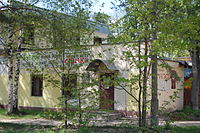

/content/dubna_images/200px-JINR_synchrophasotron.jpg


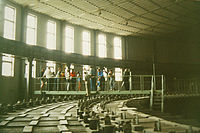

/content/dubna_images/200px-City_Hall_Dubna.JPG


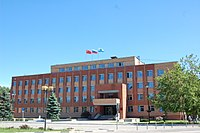

/content/dubna_images/220px-%D0%A4%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9_%D0%B4%D0%BE%D0%BC_%D0%BD%D0%B0_%D1%83%D0%BB%D0%B8%D1%86%D0%B5_%D0%9B%D0%B5%D0%BD%D0%B8%D0%BD%D0%B0_%D0%B2_%D0%94%D1%83%D0%B1%D0%BD%D0%B5.jpg


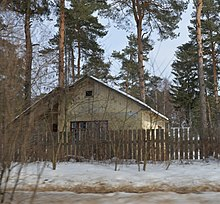

/content/dubna_images/180px-%D0%A5%D1%80%D0%B0%D0%BC_%D0%9F%D0%BE%D1%85%D0%B2%D0%B0%D0%BB%D1%8B_%D0%9F%D1%80%D0%B5%D1%81%D0%B2%D1%8F%D1%82%D0%BE%D0%B9_%D0%91%D0%BE%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%B8%D1%86%D1%8B_%D0%B2_%D0%94%D1%83%D0%B1%D0%BD%D0%B5.jpeg


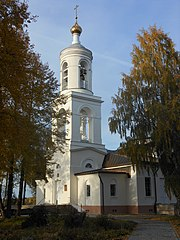

/content/dubna_images/220px-%D0%9F%D0%B0%D0%BC%D1%8F%D1%82%D0%BD%D0%B8%D0%BA_%D0%BF%D0%BE%D0%B3%D0%B8%D0%B1%D1%88%D0%B8%D0%BC_%D0%B7%D0%B5%D0%BC%D0%BB%D1%8F%D0%BA%D0%B0%D0%BC_9_%D0%BC%D0%B0%D1%8F.jpg


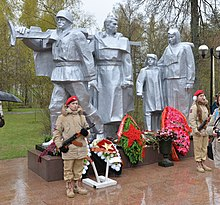

/content/dubna_images/220px-%D0%94%D0%9A_%D0%9E%D0%BA%D1%82%D1%8F%D0%B1%D1%80%D1%8C.jpg


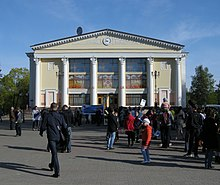

/content/dubna_images/150px-Dubna_Church_Our_Lady_Smolensk.JPG


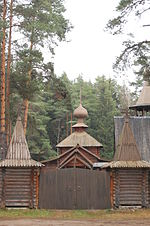

/content/dubna_images/200px-Association_Atom_Dubna.JPG


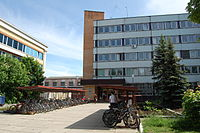

/content/dubna_images/220px-%D0%A2%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%BA%D0%B0%D0%BC_%D1%82%D1%8B%D0%BB%D0%B0.jpg


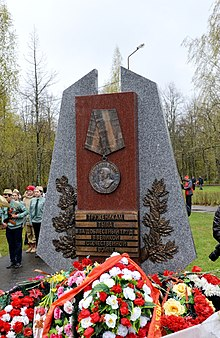

/content/dubna_images/200px-Organ_Hall_Dubna.JPG


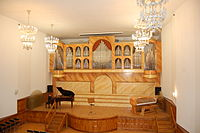

/content/dubna_images/198px-Tenzor_Dubna_Mosaic.JPG


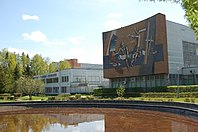

/content/dubna_images/200px-Cultur_House_Dubna.JPG


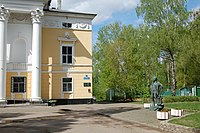

/content/dubna_images/220px-DubnaStone.jpg


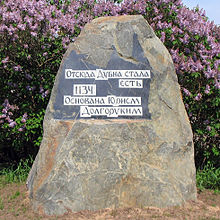

/content/dubna_images/197px-%D0%9F%D1%80%D0%BE%D1%85%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D0%94%D0%9C%D0%97_%D0%B8%D0%BC._%D0%9D.%D0%9F.%D0%A4%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%B0.jpg


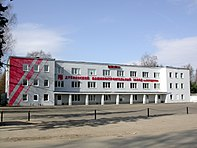

/content/dubna_images/160px-Dubna.house_of_scientiests.jpg


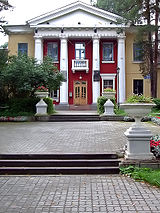

In [66]:
from IPython.display import Image
from pathlib import Path
for fname in Path('/content/dubna_images').glob('*'):
    print(fname)
    display(Image(filename=fname))


In [67]:
from skimage.io import imread_collection

col = imread_collection('/content/dubna_images/*')

In [68]:
import matplotlib.pyplot as plt

for img in col:
    plt.figure()
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Библитотека LXML - еще одна популярная библиотека парсинга HTML, но в первую очередь XML.

Документация подробна, но достаточно сложная для понимания. Например
есть два варианта парсинга html:
*   https://lxml.de/parsing.html#parsing-html
*   https://lxml.de/lxmlhtml.html#parsing-html

In [69]:
from lxml import etree
xml_tree = etree.HTML(test)
xml_tree

<Element html at 0x7f24b051be80>

In [70]:
from lxml.html import fromstring, parse
html_tree = fromstring(test)
html_tree

<Element html at 0x7f24afb0b680>

In [71]:
type(xml_tree), type(html_tree)

(lxml.etree._Element, lxml.html.HtmlElement)

lxml.html - методы специфические для html, лучше использовать его.

# Задание

Вместо Beautiful Soup использовать библиотеку [LXML](https://lxml.de/).

1. найти h2 теги с атрибутом align равным center
2. найти h2 теги у которых есть аттрибут align
3. извлечь текстовое содержимое тега с разметкой внутри
4. извлечь два первых параграфа с текстом из страницы на Википедии
5. извлечь список районов Дубны
6. извлечь таблицу климата
7. сохранить изображения

1

In [72]:
tree = fromstring(test)
for tmp in tree.xpath('//h2[@align="center"]'):
  print (tmp.text_content())

 Some text 


2

In [73]:
for tmp in tree.xpath('//h2[@align]'):
  print (tmp.text_content())

 Some text 
 Another text 


3

In [74]:
text_tag = tree.xpath('//h2')[2]
text_tag.text_content()

' Last text '

4

In [75]:
response = requests.get('https://ru.wikipedia.org/wiki/Дубна')
html_tree = fromstring(response.text)
content = html_tree.xpath('//div[@class="mw-parser-output"]')[0]

In [76]:
text = content.xpath('//p')
print (text[3].text_content())
print (text[4].text_content())

Дубна́[2] — город, наукоград на севере Московской области (121 км от Москвы), крупнейший в России центр по исследованиям в области ядерной физики. Население — 74 183[1] чел. (2021 г.).

Город расположен на реке Волге, ограничен реками Дубной и Сестрой, каналом имени Москвы и Иваньковским водохранилищем. Единственный населённый пункт Московской области, расположенный на Волге.



5

In [77]:
for tag in content.xpath('//table//tbody//tr//th'):
  if tag.text_content() == 'Внутреннее деление':
    parent = tag.getparent()
    for tmp in parent.xpath('.//td'):
      print (tmp.text_content())


Правый Берег:
Институтская часть,
Чёрная Речка,
Большая Волга,
Левый Берег:
Тридцатка,

Подберезье,


6

In [78]:
climate_data = content.xpath('//div[@class="thumbinner"]//div//table//tbody')[0]
columns = []
for th in climate_data.xpath('.//tr[1]//th'):
  columns.append(th.text_content().strip())
columns

['Показатель',
 'Янв.',
 'Фев.',
 'Март',
 'Апр.',
 'Май',
 'Июнь',
 'Июль',
 'Авг.',
 'Сен.',
 'Окт.',
 'Нояб.',
 'Дек.',
 'Год']

In [79]:
values = []
for tr in climate_data.xpath('.//tr')[1:-1]:
  tmp_values = []
  for th in tr.xpath('.//th'):
    tmp_values.append(th.text_content().strip())
  for td in tr.xpath('.//td'):
    tmp_values.append(td.text_content().strip())
  values.append(tmp_values)
climate = pd.DataFrame(values, columns=columns)
climate

,Показатель,Янв.,Фев.,Март,Апр.,Май,Июнь,Июль,Авг.,Сен.,Окт.,Нояб.,Дек.,Год
0,"Средний максимум, °C","−6,2","−5,1","0,9",10,"17,6","21,2","23,4","21,2",15,"7,8","0,3",−4,"8,5"
1,"Средняя температура, °C","−9,1","−8,7",−3,"5,1",12,"16,1","18,2","16,1","10,6","4,6",−2,"−6,5","4,4"
2,"Средний минимум, °C","−12,1",−12,"−6,5",1,"7,1","11,2","13,7","11,8","7,1","2,1","−4,1","−9,1","0,9"
3,"Норма осадков, мм",40,33,31,36,56,71,77,69,57,58,48,44,620


7

In [80]:
imageUrl = html_tree.xpath('//img[@alt=""][@class="thumbimage"]/@src')
links = ['https:' + src for src in imageUrl]
fnames = [link.split('/')[-1] for link in links]

In [81]:
cd /content

/content


In [82]:
mkdir -p /content/dubna_images

In [83]:
cd dubna_images

/content/dubna_images


In [84]:
def dwnld_image(url, save_to):
    response = requests.get(url, 
                            allow_redirects=True,
                            headers = 
                            {'User-Agent': f'StudentCode/0.1 requests/{requests.__version__}'}
    )
    print(url, response)
    if response.status_code != 200:
        raise Exception(response.text)
        
    with open(save_to, 'wb') as f:        
        f.write(response.content)

In [85]:
from time import sleep
for l, fn in zip(links, fnames):
    dwnld_image(l, '/content/dubna_images/' + fn)
    sleep(3)

https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/DubnaStone.jpg/220px-DubnaStone.jpg <Response [200]>
https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/JINR_synchrophasotron.jpg/200px-JINR_synchrophasotron.jpg <Response [200]>
https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/Dubna.house_of_scientiests.jpg/160px-Dubna.house_of_scientiests.jpg <Response [200]>
https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Tenzor_Dubna_Mosaic.JPG/198px-Tenzor_Dubna_Mosaic.JPG <Response [200]>
https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/%D0%9F%D1%80%D0%BE%D1%85%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D0%94%D0%9C%D0%97_%D0%B8%D0%BC._%D0%9D.%D0%9F.%D0%A4%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%B0.jpg/197px-%D0%9F%D1%80%D0%BE%D1%85%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D0%94%D0%9C%D0%97_%D0%B8%D0%BC._%D0%9D.%D0%9F.%D0%A4%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%B0.jpg <Response [200]>
https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Association_Atom_Dubna.JPG/200px-As

In [86]:
for img in imread_collection('/content/dubna_images/*'):
    plt.figure()
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.